In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib inline

In [2]:
# Generate some data to use
n = 500  # number of data points

x = np.random.rand(n)  # random x co-ordinates
y = 5 * x + np.random.randn(n)  # y as a function of x with some added noise
z = [chr(i) for i in np.random.randint(97, 97+8, n)]  # sample text labels

coords = pd.DataFrame({
        'x': x,
        'y': y,
        'z': z
    })

In [3]:
# Define some helper functions (should probably go into class as static methods tbh)
def categorical_lookup(series):
    unique_vals = sorted(series.unique())
    return dict(zip(unique_vals, np.arange(1, len(unique_vals) + 1)))


def facet_dimensions(number_of_plots):
    sqrt_nplots = np.sqrt(number_of_plots)
    side_length = int(sqrt_nplots)
    nrows, ncols = (side_length, side_length)
    
    if sqrt_nplots > (side_length + 0.5):
        nrows += 1
        ncols += 1
    elif sqrt_nplots > (side_length):
        nrows += 1
    
    return nrows, ncols


def apply_style_continuous(ax):
    ax.spines["bottom"].set_color('dimgray')
    ax.spines["left"].set_color('dimgray')
    ax.tick_params(colors='dimgray')
    # Remove top and bottom spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    # Remove extra ticks
    ax.get_xaxis().tick_bottom()  
    ax.get_yaxis().tick_left()
    # Set background colour
    ax.set_axis_bgcolor('snow')
    
def apply_style_discrete(ax, lookup, categorical):
    if categorical == 'x':
        ax.set_xticks(list(lookup.values()))
        ax.set_xticklabels(list(lookup.keys()))
    elif categorical == 'y':
        ax.set_yticks(list(lookup.values()))
        ax.set_yticklabels(list(lookup.keys()))

    # Change axes colour
    ax.spines["bottom"].set_color('dimgray')
    ax.spines["left"].set_color('dimgray')
    ax.tick_params(colors='dimgray')

    # Remove top and bottom spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)

    # Remove extra ticks
    if categorical == 'x':
        ax.get_xaxis().tick_bottom()  
        ax.tick_params(
            axis='x',          # changes apply to the x-axis (could do outside of loop?)
            which='both',      # both major and minor ticks are affected
            left='on',         # ticks along the bottom edge are off
            right='off'        # ticks along the top edge are off
        )

        ax.xaxis.grid(True, which='major', color='dimgray', linestyle='dotted') 
        ax.set_xlim([min(list(lookup.values())) - 1, max(list(lookup.values())) + 1])
    elif categorical == 'y':
        ax.get_yaxis().tick_left()  
        ax.tick_params(
            axis='y',          # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='on',         # ticks along the bottom edge are off
            right='off'        # ticks along the top edge are off
        )

        ax.yaxis.grid(True, which='major', color='dimgray', linestyle='dotted') 
        ax.set_ylim(
            (min(list(lookup.values())) - 1,
             max(list(lookup.values())) + 1)
        )

    # Set background colour
    ax.set_axis_bgcolor('snow')
    
    
def apply_style_blank(ax):
    ax.axis('off')

In [4]:
# The main plotting class
class CribPlot:
    def __init__(self, data, aes=None, **kwargs):
        self.data = data
        self.aes = aes
        self.fig = plt.figure(**kwargs)
        self.axes = None
        
    def aesthetics(self, x=None, y=None, by=None, **kwargs):
        if by is None:
            number_of_plots = 1

            # Create dummy variable for faceting
            by = 'by'
            self.data['by'] = 1
        else:
            number_of_plots = len(self.data[by].unique())
        
        nrows, ncols = facet_dimensions(number_of_plots)
        
        axes = [plt.subplot(nrows, ncols, i) for i in range(1, number_of_plots+1)]
        self.axes = axes
        self.aes = {
            'x': x,
            'y': y,
            'by': by
        }
        
        return self
    
    def points(self, categorical=None, aes=None, **kwargs):
        categories = sorted(self.data[self.aes['by']].unique())
        
        for i, ax in enumerate(self.axes):
            if i < len(categories):
                
                subcat = categories[i]
                plot_data = self.data.loc[lambda df: df[self.aes['by']] == subcat]
                
                xdata = plot_data[self.aes['x']]
                ydata = plot_data[self.aes['y']]

                if categorical is None:
                    # could create a kwargs dict dynamically or through a loop or something
                    ax.scatter(xdata, ydata, **kwargs)
                    apply_style_continuous(ax)
                    
                elif categorical is 'x':
                    xlookup = categorical_lookup(plot_data[self.aes['x']])
                    ax.scatter(xdata.replace(xlookup), ydata, **kwargs)
                    apply_style_discrete(ax, xlookup, categorical)
    
                elif categorical is 'y':
                    ylookup = categorical_lookup(plot_data[self.aes['y']])
                    ax.scatter(xdata, ydata.replace(ylookup), **kwargs)
                    apply_style_discrete(ax, ylookup, categorical)
                
            else:
                apply_style_blank(ax)
                
            return self
                
    def histogram(self, aes=None, **kwargs):
        categories = sorted(self.data[self.aes['by']].unique())
        
        for i, ax in enumerate(self.axes):
            if i < len(categories):
                
                subcat = categories[i]
                plot_data = self.data.loc[lambda df: df[self.aes['by']] == subcat]

                xdata = plot_data[self.aes['x']]
                
                ax.hist(xdata)
                apply_style_continuous(ax)
                
            else:
                apply_style_blank(ax)
                
        return self


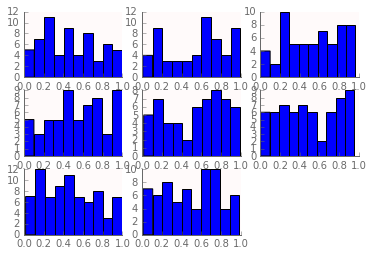

In [5]:
(CribPlot(coords)
 .aesthetics(x='x', y='y', by='z')
 .histogram())

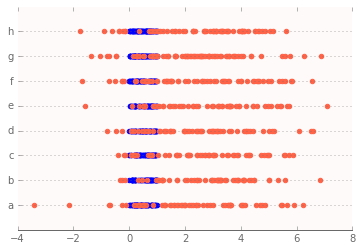

In [7]:
(coords
 .pipe(CribPlot)
 .aesthetics(x='x', y='z')
 .points(categorical='y', color='blue')
 .aesthetics(x='y', y='z')
 .points(categorical='y', color='tomato'))